- [ ] Import data
- [ ] Make into binary, based on a threshold
- [ ] Find the brighest row and column, i.e. the galaxu of our pixture. Might be able to use blob from skimage
- [ ] Rotate using some sort of PC(A?) to make it easier for our model to handle later. 
- [ ] Resise somewhere along this list to a format we choose. 

# preprocesing
- [ ] Check each image and check how many "blobs" they have. 
- [ ] Remove them 
- [ ] Check how many we have left.  

# Remove images where blob overlap 
- [ ] Check the rows we get in blob
- [ ] Using the middle point and a radius, if two blobs overlap
- [ ] We remove that image. 

In [20]:
%matplotlib inline

In [21]:
import skimage as ski
import numpy as np
import os 
import sys
import matplotlib.pyplot as plt

In [22]:
def get_image_path(galaxyID, test_true=False, train_true=False):
    if galaxyID is None:
        return None
    if isinstance(galaxyID, int):
        galaxyID = str(galaxyID)
    # Get the current working directory
    current_dir = os.getcwd()
    # Search through the subfolders for the image with the same ID
    search_dir = current_dir
    for root, dirs, files in os.walk(search_dir):
        for file in files:
            if file.startswith(galaxyID):
                return os.path.join(root, file)

    # If the image is not found, return None
    return None


In [23]:
get_image_path(747207)

'/workspaces/ClusteringGalaxies/images_training_subfolder23/747207.jpg'

In [24]:


# img = ski.io.imread(get_image_path(747207))
# img = ski.io.imread(get_image_path(262909))
# img = ski.io.imread(get_image_path(312941)) ##outlier, don't change
# img = ski.io.imread(get_image_path(732356))
# img = ski.io.imread(get_image_path(101151)) ##irregular
# img = ski.io.imread(get_image_path(458590)) ## long
img = ski.io.imread(get_image_path(459013)) ##overlap
# img = ski.io.imread(get_image_path(100295)) ##black stripe
# img = ski.io.imread(get_image_path(100774)) ##Ovelap
# img = ski.io.imread(get_image_path(100008))


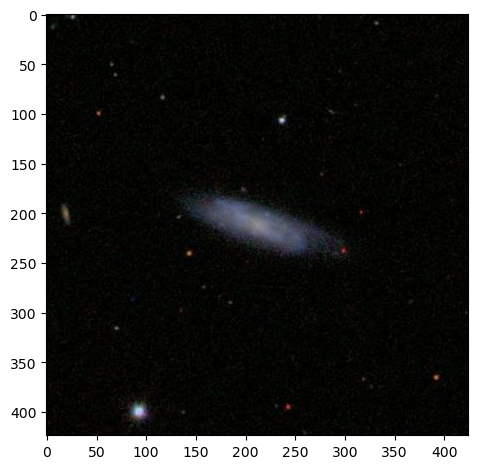

In [25]:
ski.io.imshow(img)

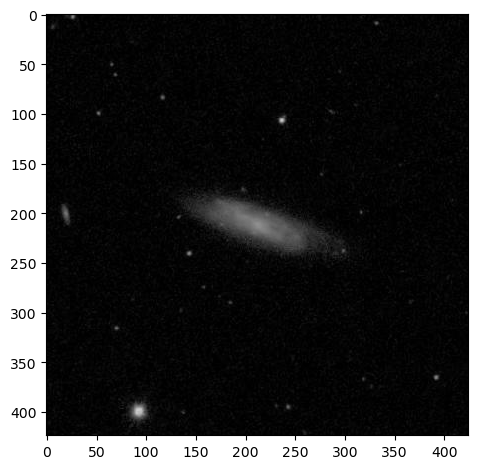

In [26]:
# Ignores colours, as that is mostly a factor of length and the shape of the galaxy is what we are aiming for. 
gray_img = ski.color.rgb2gray(img)
ski.io.imshow(gray_img)

In [27]:
class Galaxy:
    def __init__(self, x, y, sigma):
        self._x = x
        self._y = y
        self._sigma = sigma
    
    @property
    def center(self):
        return [self._x, self._y]
    
    @property
    def radius(self):
        factor = np.sqrt(2)
        return factor*self._sigma

def cropp_image(image, center_x, center_y, radius):
    return image[int(center_x-radius):int(center_x+radius), int(center_y-radius):int(center_y+radius)]

def overlap(galaxy1:Galaxy, galaxy2:Galaxy, verbose=False):
    D = np.sqrt((galaxy1.center[0]-galaxy2.center[0])**2 + (galaxy1.center[1]-galaxy2.center[1])**2)
    alpha = np.arccos(abs(galaxy1.center[0]-galaxy2.center[0])/D)
    closest_point = [int(galaxy2.center[0] + galaxy2.radius*np.cos(alpha)), int(galaxy2.center[1] + galaxy2.radius*np.sin(alpha))]
    if verbose:
        print(f"Closest point: {closest_point}")
        print(f"Distance: {D}")
        print(f"Alpha: {alpha}")
        print(f"Galaxy1 center: {galaxy1.center}")
        print(f"Galaxy2 center: {galaxy2.center}")
    # Is closest point within the radius of galaxy1?
    if np.sqrt((closest_point[0]-galaxy1.center[0])**2 + (closest_point[1]-galaxy1.center[1])**2) < galaxy1.radius:
        return True
    else:
        return False

def find_galaxy(image, window, verbose=False):
    blobs = ski.feature.blob_doh(image,
                                threshold=0.002, 
                                max_sigma = 100,
                                num_sigma=50,
                                overlap=1)
    if verbose:
        print(blobs)
    image_center = [image.shape[0]//2, image.shape[1]//2]
    found_galaxy = None
    largest_sigma = 0
    blobs_in_window = []
    for b in blobs:
        if all(abs(b[i] - image_center[i]) < window for i in range(2)) and b[2] > largest_sigma:
            blobs_in_window.append(b)
            print(f"blob considered: {b[0]}, {b[1]}, {b[2]}")
            largest_sigma = b[2]
            found_galaxy = b

    found_galaxy = Galaxy(found_galaxy[0], found_galaxy[1], found_galaxy[2])

    for b in blobs_in_window:
        blob = Galaxy(b[0], b[1], b[2])
        if blob.center != found_galaxy.center:
            # Check if they overlap
            if overlap(found_galaxy, blob, verbose=True):
                if verbose:
                    print(f"There is overlap. x1={blob.center[0]}, y1={blob.center[1]}")
                return found_galaxy #REMOVE!
    return found_galaxy
            

In [28]:

galaxy = find_galaxy(gray_img, window=50, verbose=True)

[[399.          91.           9.08163265]
 [107.         235.           3.02040816]
 [365.         391.           3.02040816]
 [240.         143.           3.02040816]
 [  2.          25.           3.02040816]
 [ 99.          51.           3.02040816]
 [315.          69.           3.02040816]
 [  0.          25.           3.02040816]
 [ 83.         116.           3.02040816]
 [394.         242.           3.02040816]
 [  9.         331.           3.02040816]
 [ 60.          68.           3.02040816]
 [200.          18.           7.06122449]
 [210.         210.          43.42857143]
 [207.         205.          33.32653061]
 [ 50.          64.           3.02040816]
 [199.         315.           3.02040816]
 [213.         212.          23.2244898 ]
 [213.         214.          21.20408163]
 [212.         222.          33.32653061]
 [237.         297.           3.02040816]
 [204.         132.           3.02040816]]
blob considered: 210.0, 210.0, 43.42857142857142


In [29]:
def check_for_black_stripe(image):
    # If there is at least 10 dark pixels in a row of any angle that are surrounded by light pixels, then there is a black stripe
    # image is cropped and gray scaled

    dark_pixel_threshold = 0.1
    dark_pixel_count_threshold = 15
    bright_pixel_threshold = 0.2

    dark_pixels = []
    for i in range(image.shape[0]):
        for j in range(image.shape[1]):
            if image[i][j] < dark_pixel_threshold:
                dark_pixels.append([i,j])
    
    bright_pixels = []
    for i in range(image.shape[0]):
        for j in range(image.shape[1]):
            if image[i][j] > bright_pixel_threshold:
                bright_pixels.append([i,j])


    suspicious_pixels = []
    # Look at a window around each dark pixel
    # If the mean of the pixels in the window is above the bright pixel threshold, add it to the list of suspicious pixels
    for pixel in dark_pixels:
        window = 5
        window_pixels = []
        for i in range(pixel[0]-window, pixel[0]+window):
            for j in range(pixel[1]-window, pixel[1]+window):
                if i >= 0 and i < image.shape[0] and j >= 0 and j < image.shape[1]:
                    window_pixels.append(image[i][j])
        if np.mean(window_pixels) > bright_pixel_threshold:
            suspicious_pixels.append(pixel)

    # Plot the suspicious pixels onto the image

    #Plot the dark pixels onto the image
    ski.io.imshow(image)
    
    for pixel in bright_pixels:
        plt.plot(pixel[1], pixel[0], 'bo')
    for pixel in dark_pixels:
        plt.plot(pixel[1], pixel[0], 'ro')
    for pixel in suspicious_pixels:
        plt.plot(pixel[1], pixel[0], 'go')
    plt.show()

    # How many suspicious pixels are there?
    if len(suspicious_pixels) > dark_pixel_count_threshold:
        # Do linear regression on the suspicious pixels
        # If the R^2 value is high, then there is a black stripe

        # Get the x and y values of the suspicious pixels
        x = []
        y = []
        for pixel in suspicious_pixels:
            x.append(pixel[0])
            y.append(pixel[1])
        # Do linear regression with numpy
        slope, intercept = np.polyfit(x, y, 1)
        #Plot the line
        plt.plot(x, y, 'ro')
        plt.plot(x, [slope*x[i] + intercept for i in range(len(x))], 'b')
        plt.show()
        # Get the R^2 value
        r_squared = np.corrcoef(x, y)[0,1]**2
        # If the R^2 value is high, then there is a black stripe
        print(f"R^2 = {r_squared}")
        if r_squared > 0.7:
            print("Black Stripe found")
            return True
        else:
            print("Black Stripe was not found")
            return False
    else:
        return False

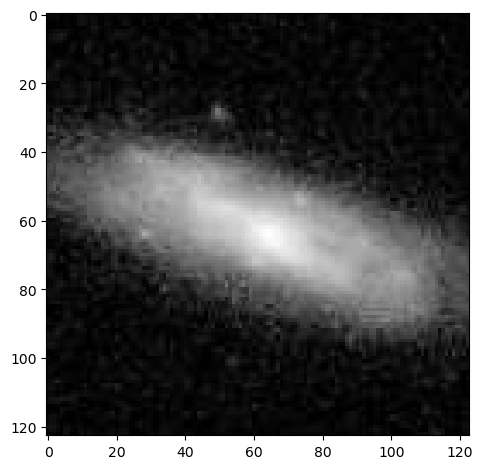

In [30]:
cropped_img = cropp_image(gray_img, galaxy.center[0], galaxy.center[1], galaxy.radius)
cropped_exposed_img = ski.exposure.rescale_intensity(cropped_img)
ski.io.imshow(cropped_exposed_img)


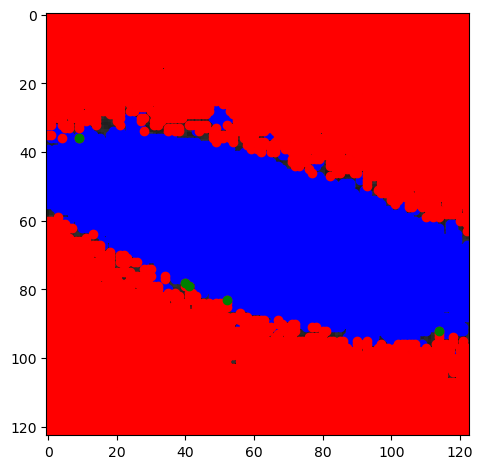

False

In [31]:
check_for_black_stripe(cropped_exposed_img)

In [32]:
def get_covariance_matrix(image, x_size, y_size):
    coord_rows = []
    coord_columns = []
    for index_row in range(0, x_size):
        for index_column in range(0, y_size):
            if image[index_row][index_column] == 1:
                coord_rows.append(index_row)
                coord_columns.append(index_column)
    cov_matrix = np.cov(coord_rows, y=coord_columns)
    return cov_matrix


cov_matrix[0] = 	[116.92928283371118, 186.4665731650304]
cov_matrix[1] = 	[186.4665731650304, 557.4214118747083]
Eigenvalues     = 	[48.595875033884695, 625.7548196745347]
eigenvectors[0] = 	[-0.9389376077564422, 0.3440874434509482]
eigenvectors[1] = 	[0.3440874434509482, 0.9389376077564422]
0.3440874434509482
0.3440874434509482
Rotating images with the deg -69.87390011876242


/opt/conda/lib/python3.11/site-packages/skimage/io/_plugins/matplotlib_plugin.py:162: UserWarning: The figure layout has changed to tight
  ax.get_figure().tight_layout()


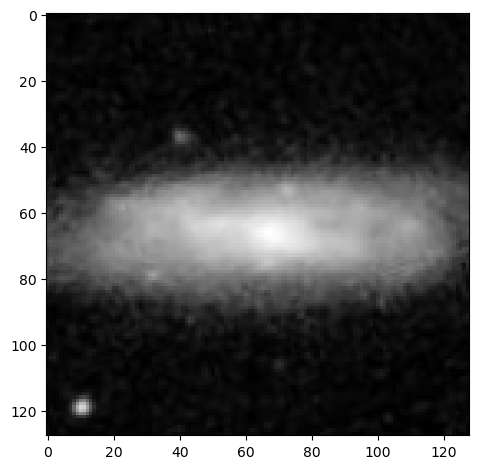

In [33]:
def get_rotation_on_image(image, verbose=False):
    binary_image = ski.util.img_as_bool(image)
    if verbose:
        ski.io.imshow(binary_image)
        pass
    
    cov_matrix = get_covariance_matrix(binary_image, len(binary_image), len(binary_image[0]))
    
    if verbose:
        print(f"cov_matrix[0] = \t[{cov_matrix[0][0]}, {cov_matrix[0][1]}]")
        print(f"cov_matrix[1] = \t[{cov_matrix[1][0]}, {cov_matrix[1][1]}]")
    result = np.linalg.eigh(cov_matrix)
    eigenvalues = result[0]
    eigenvectors = result[1]

    
    max_eigen_index, = np.where(np.isclose(eigenvalues, max(eigenvalues)))[0]
    if verbose:
        print(f"Eigenvalues     = \t[{eigenvalues[0]}, {eigenvalues[1]}]")
        print(f"eigenvectors[0] = \t[{eigenvectors[0][0]}, {eigenvectors[0][1]}]")
        print(f"eigenvectors[1] = \t[{eigenvectors[1][0]}, {eigenvectors[1][1]}]")
        print(eigenvectors[max_eigen_index][0])
        print(eigenvectors[(max_eigen_index+1)%2][1])
    rotations_in_radians = np.arccos((eigenvectors[max_eigen_index][0]+eigenvectors[(max_eigen_index+1)%2][1]) / 2)
    rotation_in_degrees = np.rad2deg(rotations_in_radians)
    if rotation_in_degrees > 90:
        rotation_in_degrees = 180 - rotation_in_degrees


    if (eigenvectors[max_eigen_index][0] * eigenvectors[max_eigen_index][1]) > 0:
        rotation_in_degrees = -rotation_in_degrees

    if verbose:
        print("Rotating images with the deg", rotation_in_degrees)
        # ski.io.imshow(ski.transform.rotate(image, rotation_in_degrees))

    return rotation_in_degrees+90

angle = get_rotation_on_image(cropped_exposed_img, verbose=True)
rotated_image = ski.transform.rotate(gray_img, angle)
cropped_rotated_img = cropp_image(rotated_image, galaxy.center[0], galaxy.center[1], galaxy.radius)
resized_cropped_rotated_image = ski.transform.resize(cropped_rotated_img, (128, 128))
resized_cropped_rotated_image = ski.exposure.rescale_intensity(resized_cropped_rotated_image)
ski.io.imshow(resized_cropped_rotated_image)

In [38]:
def filter_image(img, verbose=False):
    """
    Very simple function that is only supposed to use already existing functions with minimal interaction to handle a picture.
    
    It should return true if it's filtered out and false if it's not.
    """
    gray_img = ski.color.rgb2gray(img)
    galaxy = find_galaxy(gray_img, window=50, verbose=verbose) 
    if galaxy is None:
        return True
    
    cropped_img = cropp_image(gray_img, galaxy.center[0], galaxy.center[1], galaxy.radius)
    cropped_exposed_img = ski.exposure.rescale_intensity(cropped_img)
    return_value = check_for_black_stripe(cropped_exposed_img) ## Not implemented
    if return_value is not None:
        return True
    return False
def preprocess_image(img, verbose=False):
    """
    Function that should handle the image and return a cropped and rotated image.
    """  
    gray_img = ski.color.rgb2gray(img)  
    cropped_img = cropp_image(gray_img, galaxy.center[0], galaxy.center[1], galaxy.radius)
    cropped_exposed_img = ski.exposure.rescale_intensity(cropped_img)
    angle = get_rotation_on_image(cropped_exposed_img, verbose=verbose)
    rotated_image = ski.transform.rotate(gray_img, angle)
    cropped_rotated_img = cropp_image(rotated_image, galaxy.center[0], galaxy.center[1], galaxy.radius)
    resized_cropped_rotated_image = ski.transform.resize(cropped_rotated_img, (128, 128))
    resized_cropped_rotated_image = ski.exposure.rescale_intensity(resized_cropped_rotated_image)


Image[0]
[[204.         395.          11.10204082]
 [267.         395.          11.10204082]
 [317.         411.          13.12244898]
 [123.         291.          11.10204082]
 [213.         207.          19.18367347]
 [  8.         249.           7.06122449]
 [262.         278.           7.06122449]
 [171.         156.           7.06122449]
 [419.         122.           7.06122449]
 [ 90.         403.           5.04081633]
 [  0.         401.           5.04081633]]
blob considered: 213.0, 207.0, 19.183673469387752


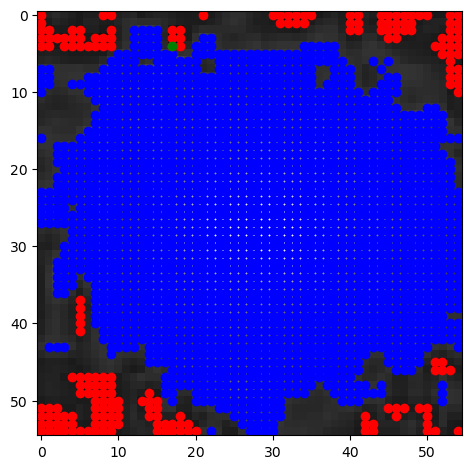

Image[0] was filtered out
Image[1]
[[213.         208.          45.44897959]
 [212.         208.          33.32653061]]
blob considered: 213.0, 208.0, 45.44897959183673


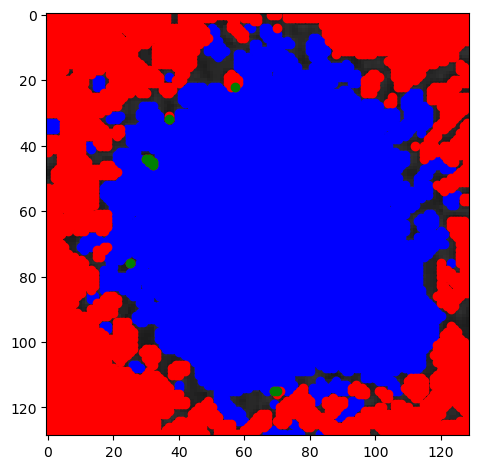

Image[1] was filtered out
Image[2]
[[210.         213.          51.51020408]
 [210.         212.          33.32653061]
 [ 61.          83.          31.30612245]
 [217.         221.         100.        ]
 [207.         318.          13.12244898]
 [  0.           0.          41.40816327]
 [  0.          41.          39.3877551 ]
 [  0.         135.           9.08163265]]
blob considered: 210.0, 213.0, 51.51020408163265
blob considered: 217.0, 221.0, 100.0
Closest point: [257, 267]
Distance: 10.63014581273465
Alpha: 0.8519663271732721
Galaxy1 center: [217.0, 221.0]
Galaxy2 center: [210.0, 213.0]
There is overlap. x1=210.0, y1=213.0


KeyboardInterrupt: 

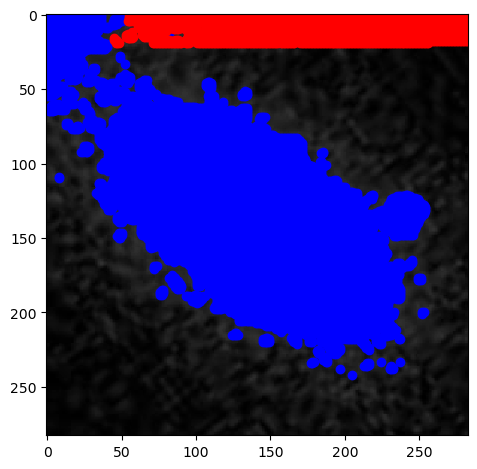

In [39]:
# FLAGS 
FILTER_IMAGES = True
PREPROCESS_IMAGES = True
VERBOSE = True
VERBOSE_FUNCTIONS = True
# Check if the folder, images_training_subfolder31, exists
FOLDER_OF_INTEREST = "images_training_subfolder31"

if not os.path.isdir(FOLDER_OF_INTEREST):
    print(f"The folder {FOLDER_OF_INTEREST} does not exist. Please download from the Kaggle website and split if needed.")
    raise SystemExit
image_collection = ski.io.imread_collection(f"./{FOLDER_OF_INTEREST}/*.jpg", conserve_memory=True)
for index, image in enumerate(image_collection):

    if VERBOSE:
        print(f"Image[{index}]")

    if FILTER_IMAGES:
        return_value = filter_image(image, VERBOSE_FUNCTIONS) 
        if return_value is True:
            if VERBOSE:
                print(f"Image[{index}] was filtered out")
            continue
    
    if VERBOSE:
        print("Image passed filter")

    if PREPROCESS_IMAGES:
        preprocessed_image = preprocess_image(return_img, VERBOSE_FUNCTIONS)

    if VERBOSE:
        print("Image was preprocessed")

    ski.io.imshow(preprocessed_image)
   


In [ ]:
len(image_collection)

0